In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
from scipy.signal import resample_poly

from pathlib import Path
import glob
import shutil
import os
import pickle

import sys
sys.path.append('/storage3/eva/code/remapping/src')
import path_formatting as pf
import motive
import utils
import oe

In [2]:
date = "20250922" # change this according to ur session
animal = "eb03"

oe_sr = 30000
m_sr = 120

_, ks_path, csv_path, res_path = utils.path_load(date, animal,p=True)

pitch_path = Path(res_path) / "pitch"
pitch_path.mkdir(parents=True, exist_ok=True) # Create the folder if it doesn't exist

Ola! For folders inside of res_path: Path(res_path)/"folder_name"
To make new folder (if not exist): your_path.mkdir(parents=True, exist_ok=True)


In [8]:
goodspiketimes = oe.ks_load(ks_path)
with open(Path(f'{res_path}/preprocessing') / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
    periods = pickle.load(f)

Sup! U have...
59 phy-good clusters


In [3]:
csv_dict = motive.get_csv_dict(csv_path)

with open(Path(f'{res_path}/preprocessing') / f"meta_{date}.pkl", "rb") as f:
    meta = pickle.load(f)

meta

{'of1': '20250922_4', 'of2': '20250922_1', 'of3': '20250922_6'}

In [4]:
with open(Path(res_path) / "preprocessing" / f"smooth_pitch_dict_{date}.pkl", "rb") as f:
    smooth_pitch_dict = pickle.load(f)
smooth_pitch_dict

{'sigma': 3,
 'of1': array([-44.29601696, -44.1299626 , -43.81168235, ...,  56.88147499,
         57.38630856,  57.66271865], shape=(181512,)),
 'of2': array([ -6.30112832,  -6.32028458,  -6.36090926, ..., -36.42524358,
        -36.43815322, -36.45213117], shape=(180193,)),
 'of3': array([54.12514684, 54.3006722 , 54.56962971, ..., 50.78501435,
        51.20551671, 51.43043394], shape=(181186,))}

In [148]:
trial_key = 'of2'
df = csv_dict[meta[trial_key]]

In [149]:
start, end = periods[trial_key]
goodspiketimes_period = {
    unit: spikes[(spikes >= start) & (spikes <= end)] - start
    for unit, spikes in goodspiketimes.items()
}
goodspiketimes_sec = {unit: spikes / oe_sr for unit, spikes in goodspiketimes_period.items()}

In [150]:
t = motive.get_frame_times(df)
_, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
x = arrays_interpol['X']
y = arrays_interpol['Y']
z = arrays_interpol['Z']

_,_,v = motive.speed(x, z, t)

pitch = smooth_pitch_dict[trial_key]*(-1)

t.shape, x.shape, y.shape, z.shape, pitch.shape, v.shape

((180193,), (180193,), (180193,), (180193,), (180193,), (180193,))

In [151]:
speed_cutoff = 0.02 # 2cm/s
y_thresh = 0.15 #15cm

speed_mask = (y >= y_thresh) | (v > speed_cutoff)
# speed_mask = np.where(
#     y < y_thresh,        # Condition: when y is below threshold
#     v > speed_cutoff,    # Apply speed cutoff
#     True                 # Otherwise: keep everything (don't mask)
# )

In [152]:
# oe data resampling - samples of 120freq with spike events
spikes_resampled = {unit: (spikes*m_sr).astype(int) for unit, spikes in goodspiketimes_sec.items()}

later instead of speed u can use theta

In [153]:
pitch_moving = pitch[speed_mask]
y_moving =y[speed_mask]

In [154]:
pitch_moving.shape, y_moving.shape

((173342,), (173342,))

In [155]:
def nice_edges(vmin, vmax, step):
    start = np.floor(vmin/step)*step
    stop  = np.ceil(vmax/step)*step
    return np.arange(start, stop + step, step)

In [156]:
bin_pitch_deg = 5.0   # 5° bins (try 2° if you want finer)
bin_y_m       = 0.01  # 1 cm bins

pitch_edges = nice_edges(pitch.min(), pitch.max(), bin_pitch_deg)
y_edges = nice_edges(y.min(), y.max(), bin_y_m,)

## 2D

In [135]:
occupancy_counts, _, _ = np.histogram2d(pitch_moving, y_moving, bins=[pitch_edges, y_edges])
occupancy_seconds = occupancy_counts/m_sr

#smooth
from scipy.ndimage import gaussian_filter
sigma = 1  # adjust as needed (in bins)
occupancy_smooth = gaussian_filter(occupancy_seconds, sigma=sigma, mode='nearest')
occupancy_mask = (occupancy_seconds == 0) | (occupancy_smooth < 1.0) # u can play with this threshold = 1sec..
occupancy_smooth_masked = np.where(occupancy_mask, np.nan, occupancy_smooth)

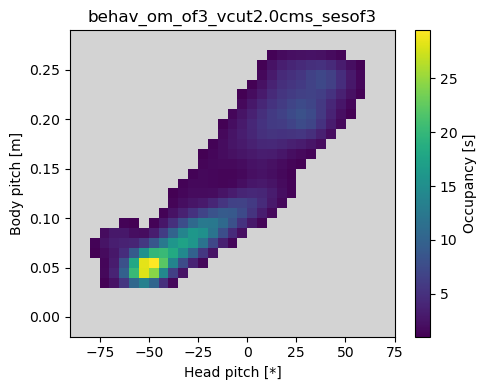

In [93]:
import matplotlib.cm as cm
save=True

plt.figure(figsize=(5,4))
cmap = cm.viridis.copy()
cmap.set_bad(color='lightgrey')
plt.imshow(
    occupancy_smooth_masked.T, 
    origin='lower', 
    extent=(pitch_edges[0], pitch_edges[-1], y_edges[0], y_edges[-1]),
    aspect='auto',
    cmap=cmap,
)
plt.colorbar(label='Occupancy [s]')
plt.xlabel('Head pitch [*]')
plt.ylabel('Body pitch [m]')
filename = f'behav_om_{trial_key}_vcut{speed_cutoff*100}cms_ses{trial_key}'
plt.title(filename)
plt.tight_layout()
if save:
    plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')
plt.show()

In [94]:
spike_maps = {}

for cell_id, spike_idxs in spikes_resampled.items():
    # Keep only spikes during movement
    spike_idxs_moving = spike_idxs[spike_idxs < len(speed_mask)]
    spike_idxs_moving = spike_idxs_moving[speed_mask[spike_idxs_moving]]

    # Get corresponding positions of spikes
    spike_p = pitch[spike_idxs_moving]
    spike_y = y[spike_idxs_moving]

    spike_count_map, _, _ = np.histogram2d(spike_p, spike_y, bins=[pitch_edges, y_edges])
    
    # Smooth
    spike_map_smooth = gaussian_filter(spike_count_map, sigma=sigma)
    spike_map_smooth_masked = np.where(occupancy_mask, np.nan, spike_map_smooth)

    spike_maps[cell_id] = spike_map_smooth_masked

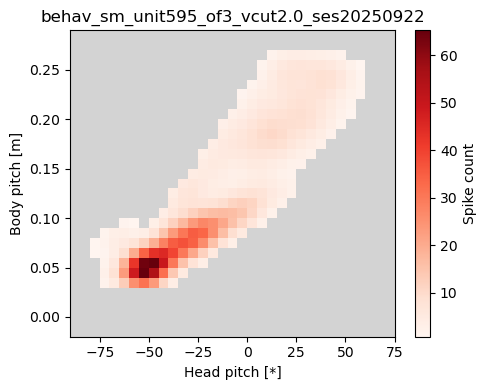

In [95]:
save=True

for unit in spike_maps.keys():

    spike_map = spike_maps[unit]

    plt.figure(figsize=(5,4))

    cmap = cm.Reds.copy()
    cmap.set_bad(color='lightgrey')  # for unvisited bins
    plt.imshow(
        spike_map.T, 
        origin='lower', 
        extent=(pitch_edges[0], pitch_edges[-1], y_edges[0], y_edges[-1]),
        aspect='auto',
        cmap=cmap,
    )
    plt.colorbar(label='Spike count')
    plt.xlabel('Head pitch [*]')
    plt.ylabel('Body pitch [m]')
    filename = f'behav_sm_unit{unit}_{trial_key}_vcut{speed_cutoff*100}_ses{date}'
    plt.title(filename)
    plt.tight_layout()

    if save:
        plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')
    if unit == list(spike_maps.keys())[0]:
        plt.show()
    plt.close()

In [96]:
place_fields = {}
for cell_id, spike_map_smooth_masked in spike_maps.items():
    rate_map = spike_map_smooth_masked / occupancy_smooth_masked
    place_fields[cell_id] = rate_map

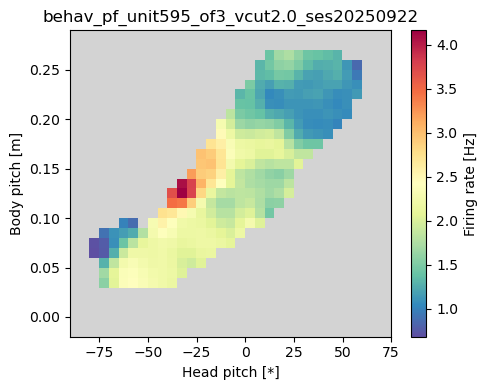

In [97]:
save=True

for unit in place_fields.keys():
    place_map = place_fields[unit]
    plt.figure(figsize=(5,4))
    cmap = cm.Spectral_r.copy()
    cmap.set_bad(color='lightgrey')  # for unvisited bins
    plt.imshow(
        place_map.T, 
        origin='lower', 
        extent=(pitch_edges[0], pitch_edges[-1], y_edges[0], y_edges[-1]),
        aspect='auto',
        cmap=cmap,
    )
    plt.colorbar(label='Firing rate [Hz]')
    plt.xlabel('Head pitch [*]')
    plt.ylabel('Body pitch [m]')
    filename = f'behav_pf_unit{unit}_{trial_key}_vcut{speed_cutoff*100}_ses{date}'
    plt.title(filename)
    plt.tight_layout()
    if save:
        plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')
    if unit == list(place_fields.keys())[0]:
        plt.show()
    plt.close()

## 1D

In [98]:
pf_data_dict1d = {}

In [99]:
bin_pitch_deg = 5.0
pitch_edges   = nice_edges(pitch.min(), pitch.max(), bin_pitch_deg)
pitch_centers = 0.5*(pitch_edges[:-1] + pitch_edges[1:])

In [100]:
occupancy_counts, _ = np.histogram(pitch_moving, bins=pitch_edges)
occupancy_seconds = occupancy_counts / m_sr # seconds per pitch bin

from scipy.ndimage import gaussian_filter1d
sigma = 1  # in bins: 5*3=15 deg smooth
occupancy_smooth = gaussian_filter1d(occupancy_seconds, sigma=sigma, mode='nearest')
occupancy_mask = (occupancy_seconds == 0) | (occupancy_smooth < 1.0) # u can play with this threshold = 1sec..
occupancy_smooth_masked = np.where(occupancy_mask, np.nan, occupancy_smooth)

In [101]:
occupancy_smooth_masked

array([         nan,   2.70749818,   6.47069948,  12.23816202,
        21.10678127,  38.09392521,  68.58178007,  98.03847435,
       101.81333396,  88.14012289,  78.10665755,  74.90482962,
        72.42384462,  66.40081515,  58.58352326,  53.2639569 ,
        50.59263577,  50.14914255,  52.80214797,  57.23429882,
        60.28344558,  60.89501704,  61.68080789,  62.85565174,
        60.42981081,  52.67787411,  40.04522322,  26.17743126,
        15.0912169 ,   7.52381037,   3.12464326,   1.14743955,
                nan])

In [102]:
pf_data_dict1d['pitch_edges'] = pitch_edges
pf_data_dict1d['pitch_centers'] = pitch_centers
pf_data_dict1d['om'] = occupancy_smooth_masked

In [103]:
occupancy_smooth_masked.shape

(33,)

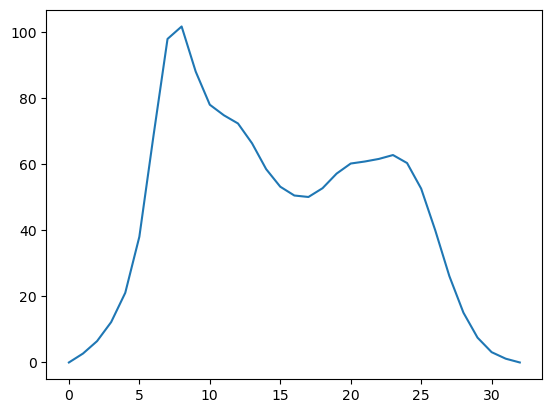

In [104]:
plt.plot(np.nan_to_num(occupancy_smooth_masked))

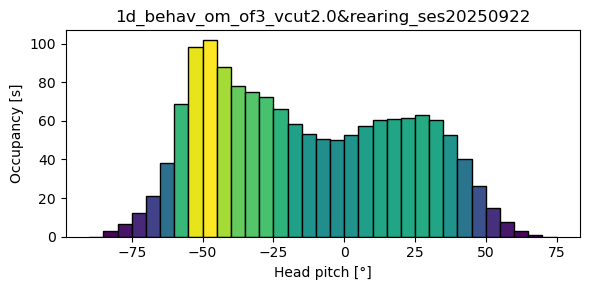

In [105]:
save=True

from matplotlib.cm import viridis
from matplotlib.colors import Normalize

# Normalize values to [0, 1]
norm = Normalize(vmin=np.nanmin(occupancy_smooth_masked), 
                 vmax=np.nanmax(occupancy_smooth_masked))

# Build a list of colors
colors = [
    'lightgrey' if np.isnan(val) else viridis(norm(val))
    for val in occupancy_smooth_masked
]

plt.figure(figsize=(6, 3))
plt.bar(pitch_centers, 
        np.nan_to_num(occupancy_smooth_masked), 
        width=bin_pitch_deg, 
        color=colors, 
        edgecolor='k')

plt.xlabel('Head pitch [°]')
plt.ylabel('Occupancy [s]')
filename = f'1d_behav_om_{trial_key}_vcut{speed_cutoff*100}&rearing_ses{date}'
plt.title(filename)
plt.tight_layout()
plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')
plt.show()

In [106]:
spike_maps_1d = {}

for cell_id, spike_idxs in spikes_resampled.items():
    # Guard: keep indices in range
    spike_idxs = spike_idxs[spike_idxs < speed_mask.size]

    # Select spikes in frames passing speed threshold
    spikes_in_bin = speed_mask[spike_idxs]
    spike_frames  = spike_idxs[spikes_in_bin]

    # Get pitch positions of those spikes
    sp = pitch[spike_frames]

    # Spike count per pitch bin
    sp_counts, _ = np.histogram(sp, bins=pitch_edges)

    # Smooth spike count (1D)
    sp_smooth = gaussian_filter1d(sp_counts, sigma=sigma)
    spike_map_smooth_masked = np.where(occupancy_mask, np.nan, sp_smooth)


    spike_maps_1d[cell_id] = spike_map_smooth_masked

In [107]:
pf_data_dict1d['sm'] = spike_maps_1d

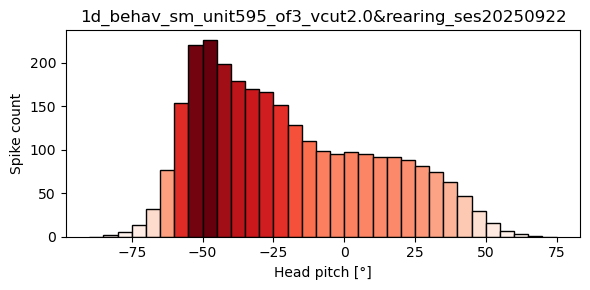

In [108]:
save=True

from matplotlib import cm
from matplotlib.colors import Normalize

for unit in spike_maps_1d.keys():

    sm = spike_maps_1d[unit]
    # Normalize for colormap (per unit)
    norm = Normalize(vmin=np.nanmin(sm), vmax=np.nanmax(sm))
    cmap = cm.Reds
    colors = [
        'lightgrey' if np.isnan(val) else cmap(norm(val))
        for val in sm
    ]
    # Plot
    plt.figure(figsize=(6, 3))
    plt.bar(pitch_centers, 
            np.nan_to_num(sm), 
            width=bin_pitch_deg, 
            color=colors, 
            edgecolor='k')

    plt.xlabel('Head pitch [°]')
    plt.ylabel('Spike count')
    filename = f'1d_behav_sm_unit{unit}_{trial_key}_vcut{speed_cutoff*100}&rearing_ses{date}'
    plt.title(filename)
    plt.tight_layout()

    if save:
        plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')
    if unit == list(spike_maps_1d.keys())[0]:
        plt.show()

    plt.close()

In [109]:
place_fields_1d = {}

for cell_id, spike_map_smooth_masked in spike_maps_1d.items():
    rate_map = spike_map_smooth_masked / occupancy_smooth_masked
    place_fields_1d[cell_id] = rate_map

pf_data_dict1d['rm'] = place_fields_1d

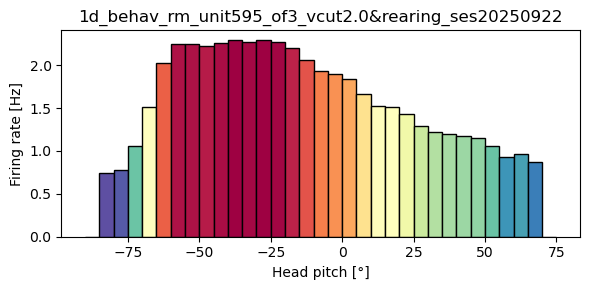

In [110]:
save=True

from matplotlib import cm
from matplotlib.colors import Normalize

for unit in place_fields_1d.keys():

    rm = place_fields_1d[unit]
    # Normalize for colormap (per unit)
    norm = Normalize(vmin=np.nanmin(rm), vmax=np.nanmax(rm))
    cmap = cm.Spectral_r
    colors = [
        'lightgrey' if np.isnan(val) else cmap(norm(val))
        for val in rm
    ]
    # Plot
    plt.figure(figsize=(6, 3))
    plt.bar(pitch_centers, 
            np.nan_to_num(rm), 
            width=bin_pitch_deg, 
            color=colors, 
            edgecolor='k')

    plt.xlabel('Head pitch [°]')
    plt.ylabel('Firing rate [Hz]')
    filename = f'1d_behav_rm_unit{unit}_{trial_key}_vcut{speed_cutoff*100}&rearing_ses{date}'
    plt.title(filename)
    plt.tight_layout()

    if save:
        plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')
    if unit == list(spike_maps_1d.keys())[0]:
        plt.show()

    plt.close()

In [111]:
# def build_rate_matrix(unit_ids, label):
#     rate_maps = []
#     valid_ids = []

#     for uid in unit_ids:
#         if uid not in place_fields_1d:
#             continue
#         rm = place_fields_1d[uid]
#         if np.all(np.isnan(rm)):
#             continue
#         max_val = np.nanmax(rm)
#         if np.isnan(max_val) or max_val == 0:
#             continue  # skip units with no meaningful activity
#         rm_norm = rm / max_val
#         if np.all(np.isnan(rm_norm)) or np.all(rm_norm == 0):
#             continue
#         rate_maps.append(rm_norm)
#         valid_ids.append(uid)

#     if len(rate_maps) == 0:
#         print(f"[{label}] No valid units after filtering.")
#         return None, None

#     rate_maps = np.array(rate_maps)

#     # Safe sort by peak pitch
#     try:
#         peak_bins = np.nanargmax(rate_maps, axis=1)
#         sort_order = np.argsort(peak_bins)
#     except ValueError:
#         print(f"[{label}] Sorting failed due to NaNs.")
#         return None, None

#     rate_maps_sorted = rate_maps[sort_order]
#     unit_ids_sorted = [valid_ids[i] for i in sort_order]

#     print(f"[{label}] Final matrix shape: {rate_maps_sorted.shape}")
#     return rate_maps_sorted, unit_ids_sorted

# # --- Build both maps ---
# rate_pyr, pyr_sorted = build_rate_matrix(pyr, "pyramidal cells")
# rate_int, int_sorted = build_rate_matrix(inter, "interneurons")

# # --- Plot helper ---
# def plot_heatmap(rate_matrix, unit_ids, label, filename_suffix):
#     if rate_matrix is None:
#         return

#     plt.figure(figsize=(10, len(unit_ids)*0.3))
#     cmap = cm.Spectral_r
#     im = plt.imshow(np.ma.masked_invalid(rate_matrix), aspect='auto', cmap=cmap,
#                     extent=(pitch_centers[0], pitch_centers[-1], 0, len(unit_ids)))

#     plt.colorbar(im, label='Normalized firing rate')
#     plt.xlabel('Head pitch [°]')
#     plt.ylabel(f'{label} (sorted)')
#     plt.yticks(np.arange(len(unit_ids)), unit_ids, fontsize=6)

#     filename = f'1d_behav_rm_{filename_suffix}_{trial_key}_vcut{speed_cutoff*100}_ses{date}.png'
#     if save:
#         plt.savefig(pitch_path / filename, dpi=300, bbox_inches='tight')
#     else:
#         plt.show()

# # --- Plot both ---
# plot_heatmap(rate_pyr, pyr_sorted, 'Pyramidal cells', 'pyr')
# plot_heatmap(rate_int, int_sorted, 'Interneurons', 'inter')

In [112]:
with open(f"{pitch_path}/pf_data_dict1d_{trial_key}_{date}.pkl", "wb") as f:
    pickle.dump(pf_data_dict1d, f)

## KDE

In [157]:
from scipy.stats import gaussian_kde

kde_maps = {}

# Create a grid of pitch values where KDEs will be evaluated
pitch_grid = np.linspace(pitch.min(), pitch.max(), 500) 

# Estimate pitch occupancy (during movement only)
kde_occ = gaussian_kde(pitch[speed_mask]) 
occupancy_kde = kde_occ(pitch_grid) 

# Loop over neurons and compute KDE-based tuning curves
for unit, spike_idxs in spikes_resampled.items():
    # Ensure spike indices are valid and during movement
    spike_idxs = spike_idxs[spike_idxs < len(speed_mask)]
    spike_idxs = spike_idxs[speed_mask[spike_idxs]]
    spike_pitch = pitch[spike_idxs]

    if len(spike_pitch) < 10: # Skip units with too few spikes for reliable KDE
        continue

    # Estimate KDE over pitch for spike positions
    kde_spike = gaussian_kde(spike_pitch)
    spike_kde = kde_spike(pitch_grid)

    # Compute firing rate estimate: spike KDE / occupancy KDE
    with np.errstate(divide='ignore', invalid='ignore'):
        rate_kde = spike_kde / occupancy_kde
        rate_kde[occupancy_kde < 1e-5] = np.nan

    kde_maps[unit] = rate_kde

In [158]:
with open(f"{pitch_path}/kde_maps_{trial_key}_{date}.pkl", "wb") as f:
    pickle.dump(kde_maps, f)

In [159]:
def stack_and_sort_maps(unit_list, kde_maps):
    # Filter only available units
    valid_units = [u for u in unit_list if u in kde_maps]

    # Stack
    matrix = np.vstack([kde_maps[u] for u in valid_units])

    # Normalize per row
    matrix_norm = matrix / np.nanmax(matrix, axis=1, keepdims=True)

    # Sort by peak
    peak_idx = np.nanargmax(matrix_norm, axis=1)
    sort_order = np.argsort(peak_idx)

    return matrix_norm[sort_order], [valid_units[i] for i in sort_order]

In [160]:
# bad_units = [
#     unit for unit, smoothed in spike_maps_1d.items()
#     if np.nanmax(smoothed) < 10
# ]

In [161]:
bad_units = [
    unit for unit, smoothed in place_fields_1d.items()
    if np.nanmax(smoothed) < 0.5
]

In [162]:
print(bad_units)

[623, 637, 645, 671, 681, 683, 719, 721, 731, 744, 750, 754, 758, 760, 782, 882]


In [163]:
# 22sep
pyr = [613,623,637,641,647,651,659,671,683,687,709,715,717,731,734,738,742,752,
       815,852,864,886,900,910,913,914]
inter_units = [645,667,681,798,815,819,862,858,860,866,894,912]
inter = [595,597,601,607,609,615,619,621,633,663,707,768,782]
noise = [681,719,721,744,750,754,758,760,882,901]

In [164]:
pyr_clean = [u for u in pyr if u not in bad_units]
inter_clean = [u for u in inter if u not in bad_units]

In [165]:
pyr_matrix, pyr_sorted = stack_and_sort_maps(pyr, kde_maps)
inter_matrix, inter_sorted = stack_and_sort_maps(inter, kde_maps)

pyr_matrix_clean, pyr_sorted_clean = stack_and_sort_maps(pyr_clean, kde_maps)
inter_matrix_clean, inter_sorted_clean = stack_and_sort_maps(inter_clean, kde_maps)

In [166]:
def plot_heatmap(matrix, pitch_grid, cell_type, filtered='all', cmap='Spectral_r'):
    plt.figure(figsize=(5, 4))
    plt.imshow(matrix, 
               aspect='auto', 
               extent=[pitch_grid[0], pitch_grid[-1], 0, matrix.shape[0]],
               origin='lower', 
               cmap=cmap)
    plt.colorbar(label='Normalized firing rate')
    plt.xlabel('Head pitch [°]')
    plt.ylabel('Units')
    filename = f'KDE_{cell_type}_{filtered}_{trial_key}_vcut{speed_cutoff*100}&rearing_ses{date}'
    plt.title(filename+'\n')
    plt.tight_layout()
    plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()

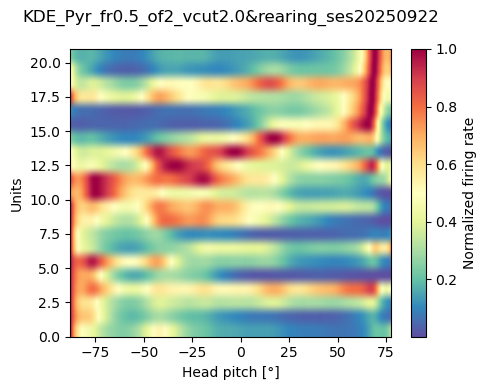

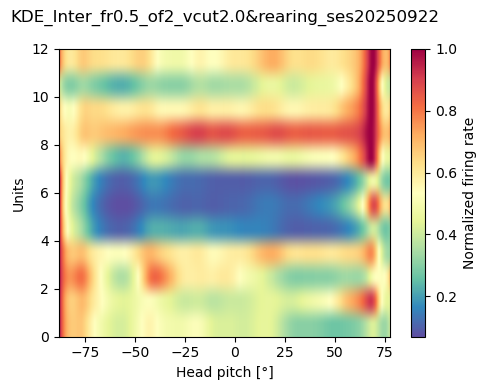

In [167]:
plot_heatmap(pyr_matrix_clean, pitch_grid, filtered='fr0.5', cell_type='Pyr')
plot_heatmap(inter_matrix_clean, pitch_grid, filtered='fr0.5', cell_type='Inter')

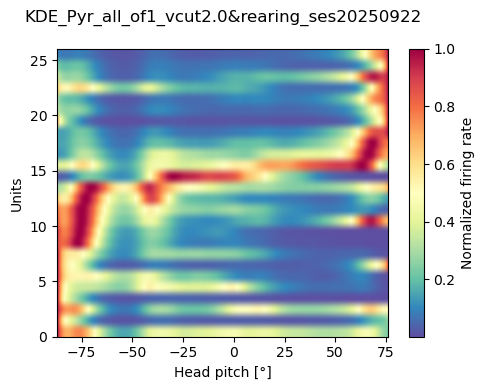

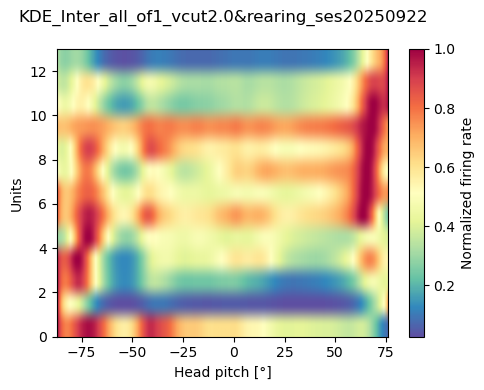

In [147]:
plot_heatmap(pyr_matrix, pitch_grid, cell_type='Pyr')
plot_heatmap(inter_matrix, pitch_grid, cell_type='Inter')

Interneurons remap behavioral tuning across space. So one can compute pitch vs distance to the arena center or z/x axis tuning maps. Same for speed

## Pitch&Distance

In [ ]:
# # distance to arena

# center_x = np.nanmean(x)
# center_z = np.nanmean(z)
# d = np.sqrt((x - center_x)**2 + (z - center_z)**2)

# speed_mask = v>speed_cutoff
# pitch_moving = pitch[speed_mask]
# d_moving = d[speed_mask]

# bin_pitch_deg = 5.0   # 5° bins (try 2° if you want finer)
# bin_d_m       = 0.05  # 5 cm bins

# pitch_edges = nice_edges(pitch.min(), pitch.max(), bin_pitch_deg)
# d_edges = nice_edges(d.min(), d.max(), bin_d_m,)

# occupancy_counts, _, _ = np.histogram2d(pitch_moving, d_moving, bins=[pitch_edges, d_edges])
# occupancy_seconds = occupancy_counts/m_sr

# #smooth
# from scipy.ndimage import gaussian_filter
# sigma = 1  # adjust as needed (in bins)
# occupancy_smooth = gaussian_filter(occupancy_seconds, sigma=sigma)

# occupancy_mask = occupancy_seconds == 0

# import matplotlib.cm as cm

# occupancy_smooth_masked = np.where(occupancy_mask, np.nan, occupancy_smooth)

# plt.figure(figsize=(5,4))

# cmap = cm.viridis.copy()
# cmap.set_bad(color='lightgrey')  # for unvisited bins

# plt.imshow(
#     occupancy_smooth_masked.T, 
#     origin='lower', 
#     extent=(pitch_edges[0], pitch_edges[-1], d_edges[0], d_edges[-1]),
#     aspect='auto',
#     cmap=cmap,
# )
# plt.colorbar(label='Occupancy [s]')
# plt.xlabel('Head pitch [*]')
# plt.ylabel('d from center [m]')

# filename = f'behav_om_{trial_key}_vcut{speed_cutoff*100}cms_ses{trial_key}'

# plt.title(filename)
# plt.tight_layout()

# # if save:
# #     plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')

# plt.show()

# spike_maps = {}

# for cell_id, spike_idxs in spikes_resampled.items():
#     # guard: keep indices in range
#     spike_idxs = spike_idxs[spike_idxs < speed_mask.size]

#     # select spikes that occur in frames of this pitch+speed mask
#     spikes_in_bin = speed_mask[spike_idxs]           # boolean per spike
#     spike_frames  = spike_idxs[spikes_in_bin]  # frame indices in this bin

#     # Get corresponding positions of spikes
#     sp = pitch[spike_frames]
#     sd = d[spike_frames]

#     # spike map (counts)
#     sp_counts, _, _ = np.histogram2d(sp, sd, bins=[pitch_edges, d_edges])

#     # smooth spike map
#     sp_smooth = gaussian_filter(sp_counts, sigma=sigma)

#     spike_maps[cell_id] = sp_smooth


# place_fields = {}
# for cell_id, spike_map_smooth in spike_maps.items():
#     rate_map = np.divide(spike_map_smooth, occupancy_smooth, 
#                          out=np.zeros_like(spike_map_smooth), 
#                          where=occupancy_smooth > 0)
#     place_fields[cell_id] = rate_map




In [ ]:
# for unit in place_fields.keys():

#     place_map = place_fields[unit]

#     place_map_masked = np.where(occupancy_mask, np.nan, place_map)

#     plt.figure(figsize=(5,4))

#     cmap = cm.Spectral_r.copy()
#     cmap.set_bad(color='lightgrey')  # for unvisited bins

#     plt.imshow(
#         place_map_masked.T, 
#         origin='lower', 
#         extent=(pitch_edges[0], pitch_edges[-1], d_edges[0], d_edges[-1]),
#         aspect='auto',
#         cmap=cmap,
#     )
#     plt.colorbar(label='Firing rate [Hz]')
#     plt.xlabel('Head pitch [*]')
#     plt.ylabel('d from the center [m]')


#     filename = f'behav_pf_unit{unit}_{trial_key}_vcut{speed_cutoff*100}_ses{date}'

#     plt.title(filename)
#     plt.tight_layout()

#     # if save:
#     #     plt.savefig(pitch_path / f"{filename}.png", dpi=300, bbox_inches='tight')
#     # if unit == list(place_fields.keys())[0]:
#     #     plt.plot()
#     plt.show()

## 3d

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
bin_pitch_deg = 5.0
bin_x = 0.05
bin_z = 0.05

pitch_edges = nice_edges(pitch.min(), pitch.max(), bin_pitch_deg)
x_edges     = nice_edges(x.min(), x.max(), bin_x)
z_edges     = nice_edges(z.min(), z.max(), bin_z)



pitch_run = pitch[speed_mask]
x_run = x[speed_mask]
z_run = z[speed_mask]

from scipy.ndimage import gaussian_filter
sigma = 1

occ_counts, _ = np.histogramdd(
    sample=(pitch_run, x_run, z_run),
    bins=(pitch_edges, x_edges, z_edges)
)

occupancy_seconds = occ_counts / m_sr
occupancy_smooth = gaussian_filter(occupancy_seconds, sigma=sigma)
occupancy_mask = occupancy_seconds == 0
occupancy_smooth_masked = np.where(occupancy_mask, np.nan, occupancy_smooth)


spike_maps_3d = {}

for cell_id, spike_idxs in spikes_resampled.items():
    spike_idxs = spike_idxs[spike_idxs < speed_mask.size]
    spike_idxs = spike_idxs[speed_mask[spike_idxs]]

    sp_pitch = pitch[spike_idxs]
    sp_x     = x[spike_idxs]
    sp_z     = z[spike_idxs]

    sp_counts, _ = np.histogramdd(
        sample=(sp_pitch, sp_x, sp_z),
        bins=(pitch_edges, x_edges, z_edges)
    )

    sp_smooth = gaussian_filter(sp_counts, sigma=1)
    spike_map_smooth_masked = np.where(occupancy_mask, np.nan, sp_smooth)
    spike_maps_3d[cell_id] = spike_map_smooth_masked

In [ ]:
place_fields_3d = {}

for cell_id, spike_map_smooth_masked in spike_maps_3d.items():
    rate_map = spike_map_smooth_masked / occupancy_smooth_masked
    place_fields_3d[cell_id] = rate_map

In [ ]:
def plot_voxel_3d_rate_map(rate_map_3d, occupancy_mask, pitch_edges, x_edges, z_edges,
                           filename="voxel_3d_map.html", threshold=0.1, opacity=0.6):
    """
    Transparent 3D voxel plot (Scatter3d) where:
    - x: X [m]
    - y: Z [m]
    - z: Pitch [°]
    - color: Firing rate
    - opacity: constant
    - voxels with no occupancy are hidden
    """
    # Bin centers
    pitch_vals = (pitch_edges[:-1] + pitch_edges[1:]) / 2
    x_vals = (x_edges[:-1] + x_edges[1:]) / 2
    z_vals = (z_edges[:-1] + z_edges[1:]) / 2

    # Create full grid
    P, X, Z = np.meshgrid(pitch_vals, x_vals, z_vals, indexing='ij')  # (pitch, x, z)

    # Flatten
    Xf = X.flatten()
    Zf = Z.flatten()
    Pf = P.flatten()
    Rf = rate_map_3d.flatten()
    # occ_mask_flat = occupancy_mask.flatten()

    # # Keep only occupied + above-threshold bins
    # keep = (Rf > threshold) & (~occ_mask_flat)
    # Xk = Xf[keep]
    # Zk = Zf[keep]
    # Pk = Pf[keep]
    # Rk = Rf[keep]

    valid_mask = (~np.isnan(Rf))

    Xk = Xf[valid_mask]
    Zk = Zf[valid_mask]
    Pk = Pf[valid_mask]
    Rk = Rf[valid_mask]

    fig = go.Figure(data=[go.Scatter3d(
        x=Xk,
        y=Zk,
        z=Pk,
        mode='markers',
        marker=dict(
            size=4.5,
            color=Rk,
            colorscale='Spectral_r',
            colorbar=dict(title='Firing rate [Hz]'),
            opacity=opacity,
            showscale=True
        )
    )])

    fig.update_layout(
        title="3D Voxel Rate Map (Pitch × X × Z)",
        scene=dict(
            xaxis_title='X [m]',
            yaxis_title='Z [m]',
            zaxis_title='Pitch [°]'
        )
    )

    filename = f'lego_plot_{unit}_{trial_key}'
    fig.write_html(res_path_path/f"{filename}.html")

In [ ]:
unit = 154 #89
plot_voxel_3d_rate_map(
    rate_map_3d=place_fields_3d[unit],
    occupancy_mask=occupancy_mask,  # shape: (n_pitch, n_x, n_z)
    pitch_edges=pitch_edges,
    x_edges=x_edges,
    z_edges=z_edges,
    threshold=0.2  # Only show active voxels
)